## Summary

This notebook takes you through an analysis of Ibis's CI data using ibis on top of [Google BigQuery](https://cloud.google.com/bigquery).

- First, we load some data and poke around at it to see what's what.
- Second, we figure out some useful things to calculate based on our poking.
- Third, we'll visualize the results of calculations to showcase what changed and how.

## Imports

Let's start out by importing ibis and turning on interactive mode.

In [2]:
import ibis
from ibis import _

ibis.options.interactive = True

## Connect to BigQuery

We connect to BigQuery using the `ibis.connect` API, which accepts a URL string indicating the backend and various bit of information needed to connect to the backend. Here we're using BigQuery, so we need the project id (`ibis-gbq`) and the dataset id (`workflows`).

Datasets are analogous to schemas in other systems.

In [3]:
url = "bigquery://ibis-gbq/workflows"
con = ibis.connect(url)

Let's see what tables are available.

In [4]:
con.list_tables()

['analysis', 'jobs', 'workflows']

## Analysis

Here we've got our first bit of interesting information: the `jobs` and `workflows` tables.

### Terminology

Before we jump in, it helps to lay down some terminology.

- A **workflow** corresponds to an individual GitHub Actions YAML file in a GitHub repository under the `.github/workflows` directory.
- A **job** is a named set of steps to run inside a **workflow** file.

### What's in the `workflows` table?

Each row in the `workflows` table corresponds to a **workflow run**.

- A **workflow run** is an instance of a workflow that was triggered by some entity: a GitHub user, bot, or other entity. Each row of the `workflows` table is a **workflow run**.

### What's in the `jobs` table?

Similarly, each row in the `jobs` table is a **job run**. That is, for a given **workflow run** there are a set of jobs run with it.

- A **job run** is an instance of a job *in a workflow*. It is associated with a single **workflow run**.

## Rationale

The goal of this analysis is to try to understand ibis's CI performance, and whether the amount of time we spent waiting on CI has decreased, stayed the same or increased. Ideally, we can understand the pieces that contribute to the change or lack thereof.

### Metrics

To that end there are a few interesting metrics to look at:

- **job run** *duration*: this is the amount of time it takes for a given job to complete
- **workflow run** *duration*: the amount of time it takes for *all* job runs in a workflow run to complete.
- **queueing** *duration*: the amount time time spent waiting for the *first* job run to commence.

### Mitigating Factors

- Around October 2021, we changed our CI infrastructure to use [Poetry](https://python-poetry.org/) instead of [Conda](https://docs.conda.io/en/latest/). The goal there was to see if we could cache dependencies using the lock file generated by poetry. We should see whether that had any effect.
- At the end of November 2022, we switch to the Team Plan (a paid GitHub plan) for the Ibis organzation. This tripled the amount of **job runs** that could execute in parallel. We should see if that helped anything.

Alright, let's jump into some data!

In [5]:
jobs = con.tables.jobs

In [6]:
jobs

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━┓
┃ url                       ┃ steps                     ┃ status    ┃ started_at          ┃ runner_group_name ┃ … ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━┩
│                           │ array<struct<status:      │           │                     │                   │   │
│ string                    │ string, conclusion:       │ string    │ timestamp           │ string            │ … │
│                           │ string, started_at:       │           │                     │                   │   │
│                           │ timestamp, number:…       │           │                     │                   │   │
├───────────────────────────┼───────────────────────────┼───────────┼─────────────────────┼───────────────────┼───┤
│ https://api.github.com/r… │ [{...}, {...}, ... +12]   │ completed │ 2020-08-04 23:54:37 │ ∅                 │ … │
│ https://api.github.com/r… │ [{...}, {...}, ... +5]    │ completed │ 2020-08-04 23:54:37 │ ∅                 │ … │
│ https://api.github.com/r… │ [{...}, {...}, ... +5]    │ completed │ 2020-08-04 23:51:54 │ ∅                 │ … │
│ https://api.github.com/r… │ [{...}, {...}, ... +12]   │ completed │ 2020-08-04 23:51:53 │ ∅                 │ … │
│ https://api.github.com/r… │ [{...}, {...}, ... +11]   │ completed │ 2020-08-04 23:50:19 │ ∅                 │ … │
│ https://api.github.com/r… │ [{...}, {...}, ... +5]    │ completed │ 2020-08-04 23:50:20 │ ∅                 │ … │
│ https://api.github.com/r… │ [{...}, {...}, ... +5]    │ completed │ 2020-08-04 23:39:58 │ ∅                 │ … │
│ https://api.github.com/r… │ [{...}, {...}, ... +9]    │ completed │ 2020-08-04 23:39:57 │ ∅                 │ … │
│ https://api.github.com/r… │ [{...}, {...}, ... +9]    │ completed │ 2020-08-04 23:34:19 │ ∅                 │ … │
│ https://api.github.com/r… │ [{...}, {...}, ... +5]    │ completed │ 2020-08-04 23:34:19 │ ∅                 │ … │
│ …                         │ …                         │ …         │ …                   │ …                 │ … │
└───────────────────────────┴───────────────────────────┴───────────┴─────────────────────┴───────────────────┴───┘

These first few columns in the `jobs` table aren't that interesting so we should look at what else is there

In [7]:
jobs.columns

['url',
 'steps',
 'status',
 'started_at',
 'runner_group_name',
 'run_attempt',
 'name',
 'labels',
 'node_id',
 'id',
 'runner_id',
 'run_url',
 'run_id',
 'check_run_url',
 'html_url',
 'runner_name',
 'runner_group_id',
 'head_sha',
 'conclusion',
 'completed_at']

A bunch of these aren't that useful for our purposes. However, `run_id`, `started_at`, `completed_at` are useful for us. The [GitHub documentation for job information](https://docs.github.com/en/rest/actions/workflow-jobs?apiVersion=2022-11-28#get-a-job-for-a-workflow-run) provides useful detail about the meaning of these fields.

- `run_id`: the workflow run associated with this job run
- `started_at`: when the job started
- `completed_at`: when the job completed

What we're interested in to a first degree is the job duration, so let's compute that.

We also need to compute when the last job for a given `run_id` started and when it completed. We'll use the former to compute the queueing duration, and the latter to compute the total time it took for a given workflow run to complete.

In [8]:
run_id_win = ibis.window(group_by=_.run_id)
jobs = jobs.select(
    _.run_id,
    job_duration=_.completed_at.cast("int") - _.started_at.cast("int"),
    last_job_started_at=_.started_at.max().over(run_id_win),
    last_job_completed_at=_.completed_at.max().over(run_id_win),
)
jobs

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ run_id    ┃ job_duration ┃ last_job_started_at ┃ last_job_completed_at ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64     │ int64        │ timestamp           │ timestamp             │
├───────────┼──────────────┼─────────────────────┼───────────────────────┤
│ 199092057 │   3148000000 │ 2020-08-07 11:24:05 │ 2020-08-07 12:16:33   │
│ 202720732 │     68000000 │ 2020-08-10 15:42:13 │ 2020-08-10 16:31:20   │
│ 202720732 │   2947000000 │ 2020-08-10 15:42:13 │ 2020-08-10 16:31:20   │
│ 240931982 │    943000000 │ 2020-09-05 20:52:43 │ 2020-09-05 20:52:43   │
│ 240931982 │    648000000 │ 2020-09-05 20:52:43 │ 2020-09-05 20:52:43   │
│ 240931982 │    562000000 │ 2020-09-05 20:52:43 │ 2020-09-05 20:52:43   │
│ 240931982 │    421000000 │ 2020-09-05 20:52:43 │ 2020-09-05 20:52:43   │
│ 240931982 │    469000000 │ 2020-09-05 20:52:43 │ 2020-09-05 20:52:43   │
│ 240931982 │   3244000000 │ 2020-09-05 20:52:43 │ 2020-09-05 20:52:43   │
│ 240931982 │            0 │ 2020-09-05 20:52:43 │ 2020-09-05 20:52:43   │
│         … │            … │ …                   │ …                     │
└───────────┴──────────────┴─────────────────────┴───────────────────────┘

Let's take a look at `workflows`

In [9]:
workflows = con.tables.workflows

In [10]:
workflows

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━┓
┃ workflow_url              ┃ workflow_id ┃ triggering_actor ┃ run_number ┃ run_attempt ┃ updated_at          ┃ … ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━┩
│ string                    │ int64       │ struct<subscrip… │ int64      │ int64       │ timestamp           │ … │
├───────────────────────────┼─────────────┼──────────────────┼────────────┼─────────────┼─────────────────────┼───┤
│ https://api.github.com/r… │     2100986 │ ∅                │         13 │           1 │ 2020-08-04 23:57:03 │ … │
│ https://api.github.com/r… │     2100986 │ ∅                │         12 │           1 │ 2020-08-04 23:55:08 │ … │
│ https://api.github.com/r… │     2100986 │ ∅                │         11 │           1 │ 2020-08-04 23:52:58 │ … │
│ https://api.github.com/r… │     2100986 │ ∅                │         10 │           1 │ 2020-08-04 23:42:41 │ … │
│ https://api.github.com/r… │     2100986 │ ∅                │          9 │           1 │ 2020-08-04 23:36:32 │ … │
│ https://api.github.com/r… │     2100986 │ ∅                │          8 │           1 │ 2020-08-04 23:31:43 │ … │
│ https://api.github.com/r… │     2100986 │ ∅                │          7 │           1 │ 2020-08-04 23:19:50 │ … │
│ https://api.github.com/r… │     2100986 │ ∅                │          6 │           1 │ 2020-08-04 23:14:16 │ … │
│ https://api.github.com/r… │     2100986 │ ∅                │          5 │           1 │ 2020-08-04 23:05:14 │ … │
│ https://api.github.com/r… │     2100986 │ ∅                │          4 │           1 │ 2020-08-04 23:01:32 │ … │
│ …                         │           … │ …                │          … │           … │ …                   │ … │
└───────────────────────────┴─────────────┴──────────────────┴────────────┴─────────────┴─────────────────────┴───┘

Again we have a bunch of columns that aren't so useful to us, so let's see what else is there.

In [11]:
workflows.columns

['workflow_url',
 'workflow_id',
 'triggering_actor',
 'run_number',
 'run_attempt',
 'updated_at',
 'cancel_url',
 'rerun_url',
 'check_suite_node_id',
 'pull_requests',
 'id',
 'node_id',
 'status',
 'repository',
 'jobs_url',
 'previous_attempt_url',
 'artifacts_url',
 'html_url',
 'head_sha',
 'head_repository',
 'run_started_at',
 'head_branch',
 'url',
 'event',
 'name',
 'actor',
 'created_at',
 'check_suite_url',
 'check_suite_id',
 'conclusion',
 'head_commit',
 'logs_url']

We don't care about many of these for the purposes of this analysis, however we need the `id` and a few values derived from the `run_started_at` column.

- `id`: the unique identifier of the **workflow run**
- `run_started_at`: the time the workflow run started

We compute the date the run started at so we can later compare it to the dates where we added poetry and switched to the team plan.

In [12]:
workflows = workflows.select(
    _.id, _.run_started_at, started_date=_.run_started_at.date()
)
workflows

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ id        ┃ run_started_at      ┃ started_date ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ int64     │ timestamp           │ date         │
├───────────┼─────────────────────┼──────────────┤
│ 195478382 │ 2020-08-04 23:54:29 │ 2020-08-04   │
│ 195476517 │ 2020-08-04 23:51:44 │ 2020-08-04   │
│ 195475525 │ 2020-08-04 23:50:11 │ 2020-08-04   │
│ 195468677 │ 2020-08-04 23:39:51 │ 2020-08-04   │
│ 195465343 │ 2020-08-04 23:34:11 │ 2020-08-04   │
│ 195460611 │ 2020-08-04 23:29:07 │ 2020-08-04   │
│ 195452505 │ 2020-08-04 23:17:29 │ 2020-08-04   │
│ 195447886 │ 2020-08-04 23:11:35 │ 2020-08-04   │
│ 195435521 │ 2020-08-04 23:02:34 │ 2020-08-04   │
│ 195433385 │ 2020-08-04 23:01:00 │ 2020-08-04   │
│         … │ …                   │ …            │
└───────────┴─────────────────────┴──────────────┘

We need to associate jobs and workflows somehow, so let's join them on the relevant key fields.

In [13]:
joined = jobs.join(workflows, jobs.run_id == workflows.id)
joined

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━┓
┃ run_id    ┃ job_duration ┃ last_job_started_at ┃ last_job_completed_at ┃ id        ┃ run_started_at      ┃ … ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━┩
│ int64     │ int64        │ timestamp           │ timestamp             │ int64     │ timestamp           │ … │
├───────────┼──────────────┼─────────────────────┼───────────────────────┼───────────┼─────────────────────┼───┤
│ 637414690 │            0 │ 2021-03-09 23:40:16 │ 2021-03-09 23:40:16   │ 637414690 │ 2021-03-09 22:59:31 │ … │
│ 637412930 │   2146000000 │ 2021-03-09 23:38:33 │ 2021-03-10 00:17:30   │ 637412930 │ 2021-03-09 22:58:27 │ … │
│ 637412930 │   1329000000 │ 2021-03-09 23:38:33 │ 2021-03-10 00:17:30   │ 637412930 │ 2021-03-09 22:58:27 │ … │
│ 637412930 │   2979000000 │ 2021-03-09 23:38:33 │ 2021-03-10 00:17:30   │ 637412930 │ 2021-03-09 22:58:27 │ … │
│ 637412930 │   1527000000 │ 2021-03-09 23:38:33 │ 2021-03-10 00:17:30   │ 637412930 │ 2021-03-09 22:58:27 │ … │
│ 637412930 │   1585000000 │ 2021-03-09 23:38:33 │ 2021-03-10 00:17:30   │ 637412930 │ 2021-03-09 22:58:27 │ … │
│ 637412930 │    985000000 │ 2021-03-09 23:38:33 │ 2021-03-10 00:17:30   │ 637412930 │ 2021-03-09 22:58:27 │ … │
│ 637412930 │   2455000000 │ 2021-03-09 23:38:33 │ 2021-03-10 00:17:30   │ 637412930 │ 2021-03-09 22:58:27 │ … │
│ 637412930 │   1305000000 │ 2021-03-09 23:38:33 │ 2021-03-10 00:17:30   │ 637412930 │ 2021-03-09 22:58:27 │ … │
│ 637412930 │   1015000000 │ 2021-03-09 23:38:33 │ 2021-03-10 00:17:30   │ 637412930 │ 2021-03-09 22:58:27 │ … │
│         … │            … │ …                   │ …                     │         … │ …                   │ … │
└───────────┴──────────────┴─────────────────────┴───────────────────────┴───────────┴─────────────────────┴───┘

Sweet! Now we have workflow runs and job runs together in the same table, let's start exploring summarization.

Let's encode our knowledge about when the poetry move happened and also when we moved to the team plan.

In [14]:
from datetime import date

POETRY_MERGED_DATE = date(2021, 10, 15)
TEAMIZATION_DATE = date(2022, 11, 28)

Let's compute some indicator variables indicating whether a given row contains data after poetry changes occurred, and do the same for the team plan.

Let's also compute queueing time and workflow duration.

In [15]:
stats = joined.select(
    _.started_date,
    _.job_duration,
    has_poetry=_.started_date > POETRY_MERGED_DATE,
    has_team=_.started_date > TEAMIZATION_DATE,
    queueing_time=_.last_job_started_at.cast("int")
    - _.run_started_at.cast("int"),
    workflow_duration=_.last_job_completed_at.cast("int")
    - _.run_started_at.cast("int"),
)
stats

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ started_date ┃ job_duration ┃ has_poetry ┃ has_team ┃ queueing_time ┃ workflow_duration ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ date         │ int64        │ boolean    │ boolean  │ int64         │ int64             │
├──────────────┼──────────────┼────────────┼──────────┼───────────────┼───────────────────┤
│ 2021-08-02   │    286000000 │ False      │ False    │      12000000 │         823000000 │
│ 2021-08-02   │    274000000 │ False      │ False    │      12000000 │         823000000 │
│ 2021-08-02   │    397000000 │ False      │ False    │      12000000 │         823000000 │
│ 2021-08-02   │    394000000 │ False      │ False    │      12000000 │         823000000 │
│ 2021-08-02   │    709000000 │ False      │ False    │      12000000 │         823000000 │
│ 2021-08-02   │    760000000 │ False      │ False    │      12000000 │         823000000 │
│ 2021-08-02   │    717000000 │ False      │ False    │      12000000 │         823000000 │
│ 2021-08-02   │    419000000 │ False      │ False    │      12000000 │         823000000 │
│ 2021-08-02   │    503000000 │ False      │ False    │      12000000 │         823000000 │
│ 2021-08-02   │    811000000 │ False      │ False    │      12000000 │         823000000 │
│ …            │            … │ …          │ …        │             … │                 … │
└──────────────┴──────────────┴────────────┴──────────┴───────────────┴───────────────────┘

Let's create a column ranging from 0 to 2 inclusive where:

- 0: no improvements
- 1: just poetry
- 2: poetry and the team plan

Let's also give them some names that'll look nice on our plots.

In [16]:
stats = stats.mutate(
    raw_improvements=_.has_poetry.cast("int") + _.has_team.cast("int")
).mutate(
    improvements=(
        _.raw_improvements.case()
        .when(0, "None")
        .when(1, "Poetry")
        .when(2, "Poetry + Team Plan")
        .else_("NA")
        .end()
    ),
    team_plan=ibis.where(_.raw_improvements > 1, "Poetry + Team Plan", "None"),
)
stats

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━┓
┃ started_date ┃ job_duration ┃ has_poetry ┃ has_team ┃ queueing_time ┃ workflow_duration ┃ raw_improvements ┃ … ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━┩
│ date         │ int64        │ boolean    │ boolean  │ int64         │ int64             │ int64            │ … │
├──────────────┼──────────────┼────────────┼──────────┼───────────────┼───────────────────┼──────────────────┼───┤
│ 2021-08-22   │    388000000 │ False      │ False    │      21000000 │         850000000 │                0 │ … │
│ 2021-08-22   │    392000000 │ False      │ False    │      21000000 │         850000000 │                0 │ … │
│ 2021-08-22   │    502000000 │ False      │ False    │      21000000 │         850000000 │                0 │ … │
│ 2021-08-22   │    515000000 │ False      │ False    │      21000000 │         850000000 │                0 │ … │
│ 2021-08-22   │    392000000 │ False      │ False    │      21000000 │         850000000 │                0 │ … │
│ 2021-08-22   │    341000000 │ False      │ False    │      21000000 │         850000000 │                0 │ … │
│ 2021-08-22   │    743000000 │ False      │ False    │      21000000 │         850000000 │                0 │ … │
│ 2021-08-22   │    630000000 │ False      │ False    │      21000000 │         850000000 │                0 │ … │
│ 2021-08-22   │    750000000 │ False      │ False    │      21000000 │         850000000 │                0 │ … │
│ 2021-08-22   │    777000000 │ False      │ False    │      21000000 │         850000000 │                0 │ … │
│ …            │            … │ …          │ …        │             … │                 … │                … │ … │
└──────────────┴──────────────┴────────────┴──────────┴───────────────┴───────────────────┴──────────────────┴───┘

Finally, we can summarize by averaging the different durations, grouping on the variables of interest.

In [17]:
USECS_PER_MIN = 60_000_000

agged = stats.group_by([_.started_date, _.improvements, _.team_plan]).agg(
    job=_.job_duration.div(USECS_PER_MIN).mean(),
    workflow=_.workflow_duration.div(USECS_PER_MIN).mean(),
    queueing_time=_.queueing_time.div(USECS_PER_MIN).mean(),
)
agged

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ started_date ┃ improvements ┃ team_plan ┃ job       ┃ workflow  ┃ queueing_time ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ date         │ string       │ string    │ float64   │ float64   │ float64       │
├──────────────┼──────────────┼───────────┼───────────┼───────────┼───────────────┤
│ 2021-11-08   │ Poetry       │ None      │  5.076520 │ 25.813687 │     17.095093 │
│ 2022-05-09   │ Poetry       │ None      │  3.645870 │ 17.563438 │     15.305701 │
│ 2022-06-04   │ Poetry       │ None      │  3.641251 │ 12.041645 │     10.759055 │
│ 2022-07-21   │ Poetry       │ None      │  3.236880 │ 13.001932 │     12.147463 │
│ 2020-12-15   │ None         │ None      │ 13.788721 │ 59.767340 │     59.767340 │
│ 2021-08-17   │ None         │ None      │  8.777027 │ 22.233333 │      7.607057 │
│ 2021-09-23   │ None         │ None      │ 11.531302 │ 93.434379 │     93.059946 │
│ 2020-09-01   │ None         │ None      │ 15.639095 │ 59.154527 │     58.680453 │
│ 2021-06-24   │ None         │ None      │  8.442157 │ 13.697059 │      0.197059 │
│ 2021-01-07   │ None         │ None      │ 12.555856 │ 48.162613 │     47.651351 │
│ …            │ …            │ …         │         … │         … │             … │
└──────────────┴──────────────┴───────────┴───────────┴───────────┴───────────────┘

If at any point you want to inspect the SQL you'll be running, ibis has you covered with `ibis.to_sql`.

In [18]:
sql = ibis.to_sql(agged)
sql

```sql
SELECT
  t0.`started_date`,
  t0.`improvements`,
  t0.`team_plan`,
  AVG(IEEE_DIVIDE(t0.`job_duration`, 60000000)) AS `job`,
  AVG(IEEE_DIVIDE(t0.`workflow_duration`, 60000000)) AS `workflow`,
  AVG(IEEE_DIVIDE(t0.`queueing_time`, 60000000)) AS `queueing_time`
FROM (
  SELECT
    t1.*,
    CASE t1.`raw_improvements`
      WHEN 0
      THEN 'None'
      WHEN 1
      THEN 'Poetry'
      WHEN 2
      THEN 'Poetry + Team Plan'
      ELSE 'NA'
    END AS `improvements`,
    CASE WHEN t1.`raw_improvements` > 1 THEN 'Poetry + Team Plan' ELSE 'None' END AS `team_plan`
  FROM (
    SELECT
      t2.*,
      CAST(t2.`has_poetry` AS INT64) + CAST(t2.`has_team` AS INT64) AS `raw_improvements`
    FROM (
      SELECT
        `started_date`,
        `job_duration`,
        `started_date` > CAST('2021-10-15' AS DATE) AS `has_poetry`,
        `started_date` > CAST('2022-11-28' AS DATE) AS `has_team`,
        UNIX_MICROS(`last_job_started_at`) - UNIX_MICROS(`run_started_at`) AS `queueing_time`,
        UNIX_MICROS(`last_job_completed_at`) - UNIX_MICROS(`run_started_at`) AS `workflow_duration`
      FROM (
        SELECT
          t5.`run_id`,
          UNIX_MICROS(t5.`completed_at`) - UNIX_MICROS(t5.`started_at`) AS `job_duration`,
          MAX(t5.`started_at`) OVER (PARTITION BY t5.`run_id`) AS `last_job_started_at`,
          MAX(t5.`completed_at`) OVER (PARTITION BY t5.`run_id`) AS `last_job_completed_at`
        FROM `ibis-gbq.workflows.jobs` AS t5
      ) AS t3
      INNER JOIN (
        SELECT
          t5.`id`,
          t5.`run_started_at`,
          DATE(t5.`run_started_at`) AS `started_date`
        FROM `ibis-gbq.workflows.workflows` AS t5
      ) AS t4
        ON t3.`run_id` = t4.`id`
    ) AS t2
  ) AS t1
) AS t0
GROUP BY
  1,
  2,
  3
```

# Plot the Results

Ibis doesn't have builtin plotting support, so we need to pull our results into pandas.

Here I'm using `plotnine` (a Python port of `ggplot2`), which has great integration with pandas DataFrames.

In [19]:
raw_df = agged.execute()

In [20]:
raw_df

,started_date,improvements,team_plan,job,workflow,queueing_time
0,2020-10-24,None,None,12.366667,54.710606,54.709091
1,2021-03-09,None,None,28.335816,52.688830,10.635284
2,2022-01-04,Poetry,None,3.288468,20.827914,20.684298
3,2021-09-30,None,None,7.993065,52.552629,51.354530
4,2022-09-14,Poetry,None,3.855526,29.760230,27.029778
...,...,...,...,...,...,...
801,2020-11-17,None,None,12.460078,40.966512,30.366744
802,2022-11-06,Poetry,None,3.937369,19.095751,16.830617
803,2020-09-23,None,None,12.086594,44.403986,43.983152
804,2020-08-28,None,None,15.834127,60.183333,60.183333


Generally, `plotnine` works with long, tidy data so let's use `pandas.melt` to get there.

In [21]:
import pandas as pd

df = pd.melt(
    raw_df,
    id_vars=["started_date", "improvements", "team_plan"],
    var_name="entity",
    value_name="duration",
)
df.head()

,started_date,improvements,team_plan,entity,duration
0,2020-10-24,None,None,job,12.366667
1,2021-03-09,None,None,job,28.335816
2,2022-01-04,Poetry,None,job,3.288468
3,2021-09-30,None,None,job,7.993065
4,2022-09-14,Poetry,None,job,3.855526


Let's make our theme lighthearted by using `xkcd`-style plots.

In [22]:
from plotnine import *

In [23]:
theme_set(theme_xkcd())

Create a few labels for our plot.

In [24]:
poetry_label = f"Poetry\n{POETRY_MERGED_DATE}"
team_label = f"Team Plan\n{TEAMIZATION_DATE}"

Without the following line you may see large amount of inconsequential warnings that make the notebook unusable.

In [25]:
import logging

# without this, findfont logging spams the notebook making it unusable
logging.getLogger('matplotlib.font_manager').disabled = True

Here we show job durations, coloring the points differently depending on whether they have no improvements, poetry, or poetry + team plan.

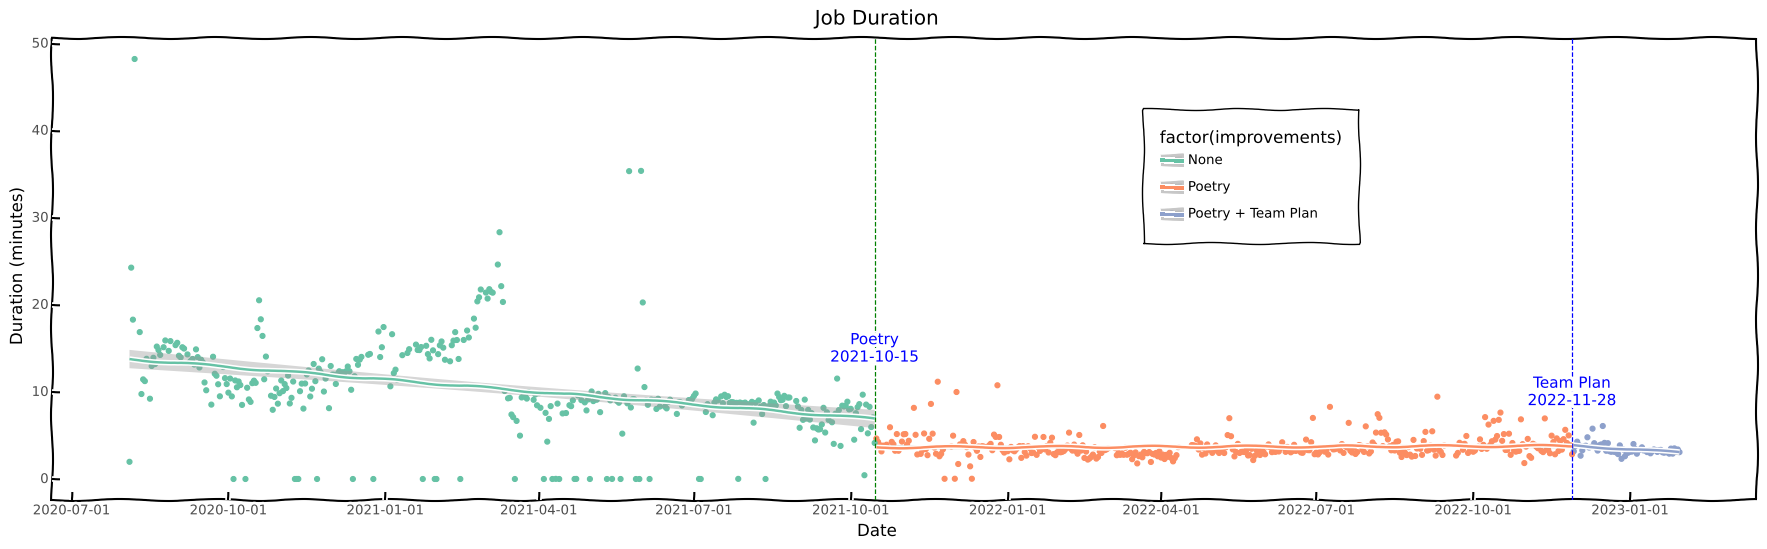

<ggplot: (8787848799950)>

In [26]:
(
    ggplot(
        df.loc[df.entity == "job"].reset_index(drop=True),
        aes(x="started_date", y="duration", color="factor(improvements)"),
    )
    + geom_point()
    + geom_vline(
        xintercept=[TEAMIZATION_DATE, POETRY_MERGED_DATE],
        colour=["blue", "green"],
        linetype="dashed",
    )
    + scale_color_brewer(
        palette=7,
        type='qual',
        limits=["None", "Poetry", "Poetry + Team Plan"],
    )
    + geom_text(x=POETRY_MERGED_DATE, label=poetry_label, y=15, color="blue")
    + geom_text(x=TEAMIZATION_DATE, label=team_label, y=10, color="blue")
    + stat_smooth(method="lm")
    + labs(x="Date", y="Duration (minutes)")
    + ggtitle("Job Duration")
    + theme(
        figure_size=(22, 6),
        legend_position=(0.67, 0.65),
        legend_direction="vertical",
    )
)

## Result #1: Job Duration

This result is pretty interesting.

A few things pop out to me right away:

- The move to poetry decreased the average job run duration by quite a bit. No, I'm not going to do any statistical tests.
- The variability of job run durations also decreased by quite a bit after introducing poetry.
- Moving to the team plan had little to no effect on job run duration.

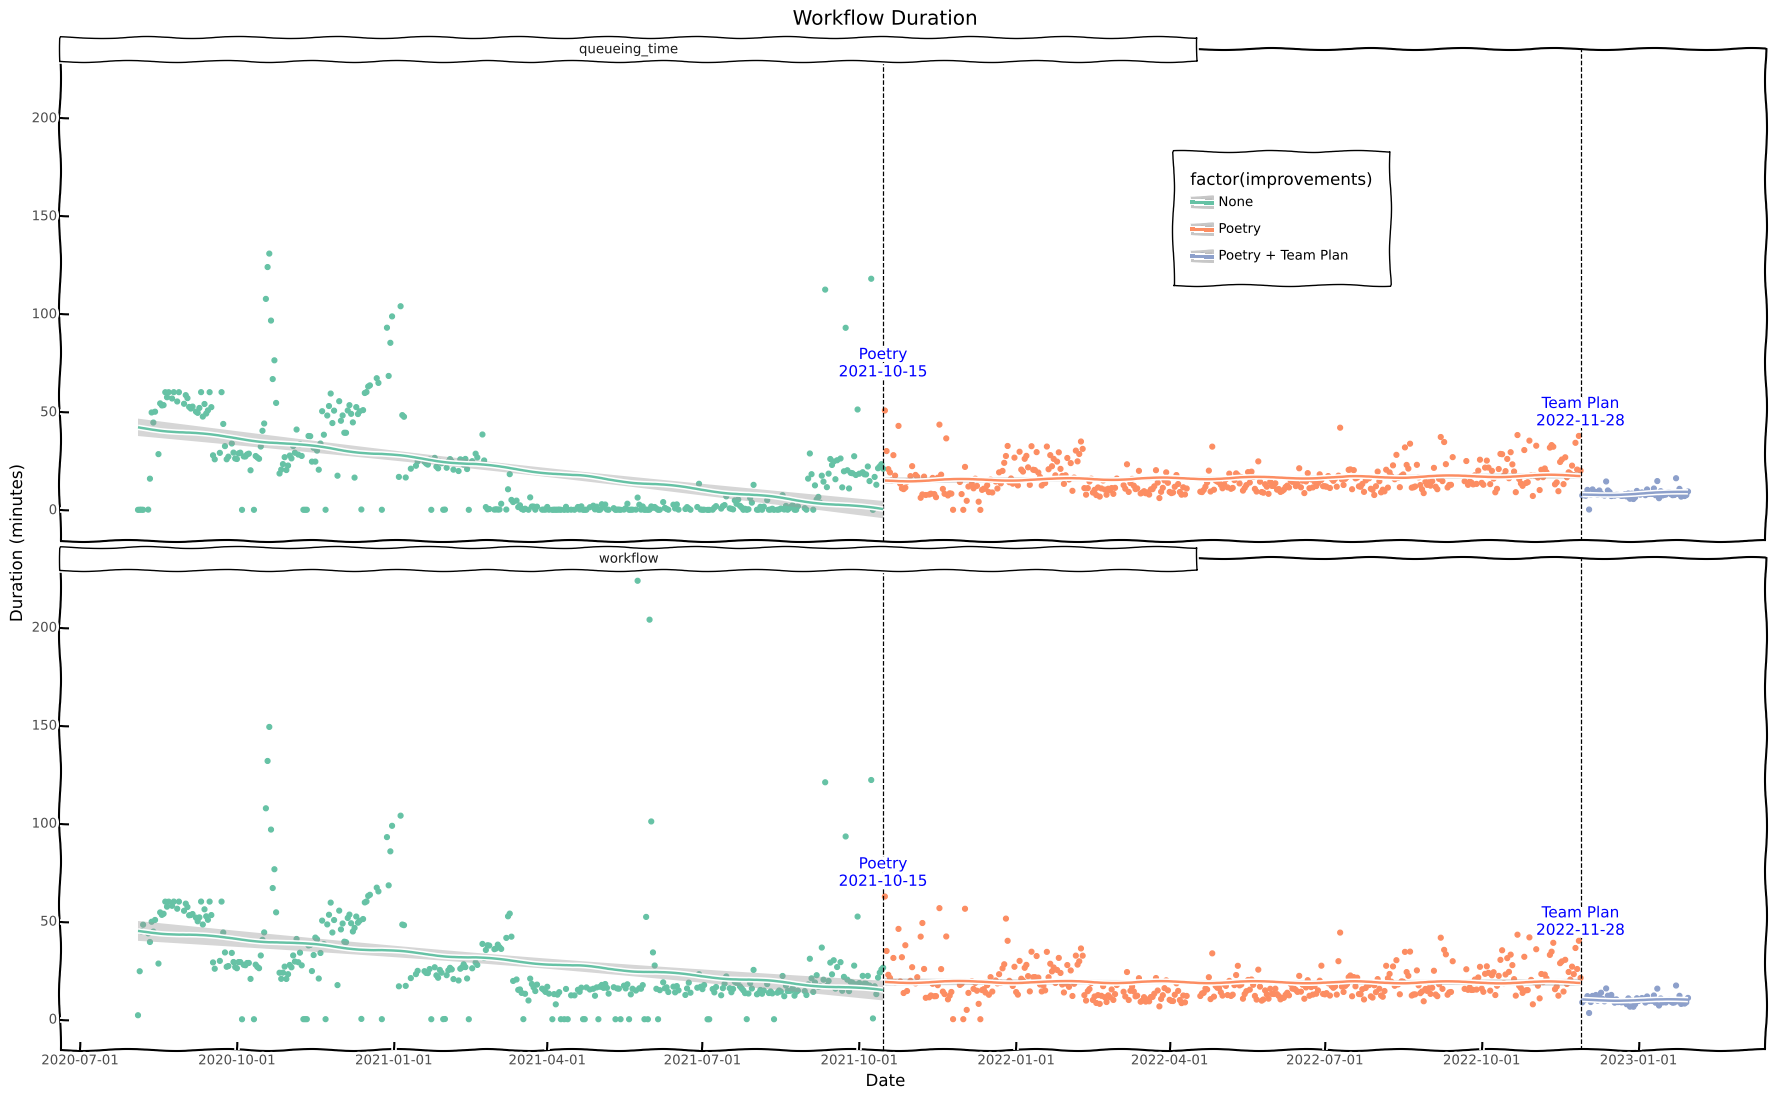

<ggplot: (8787517291848)>

In [27]:
(
    ggplot(
        df.loc[df.entity != "job"].reset_index(drop=True),
        aes(x="started_date", y="duration", color="factor(improvements)"),
    )
    + facet_wrap("entity", ncol=1)
    + geom_point()
    + geom_vline(
        xintercept=[TEAMIZATION_DATE, POETRY_MERGED_DATE],
        linetype="dashed",
    )
    + scale_color_brewer(
        palette=7,
        type='qual',
        limits=["None", "Poetry", "Poetry + Team Plan"],
    )
    + geom_text(x=POETRY_MERGED_DATE, label=poetry_label, y=75, color="blue")
    + geom_text(x=TEAMIZATION_DATE, label=team_label, y=50, color="blue")
    + stat_smooth(method="lm")
    + labs(x="Date", y="Duration (minutes)")
    + ggtitle("Workflow Duration")
    + theme(
        figure_size=(22, 13),
        legend_position=(0.68, 0.75),
        legend_direction="vertical",
    )
)

## Result #2: Workflow Duration and Queueing Time

Another interesting result.

### Queueing Time

- It almost looks like moving to poetry made average queueing time worse. This is probably due to our perception that faster jobs means faster ci. As we see here that isn't the case
- Moving to the team plan cut down the queueing time by quite a bit

### Workflow Duration

- Overall workflow duration appears to be strongly influenced by moving to the team plan, which is almost certainly due to the drop in queueing time since we are no longer limited by slow job durations.
- Perhaps it's obvious, but queueing time and workflow duration appear to be highly correlated.

In the next plot we'll look at that correlation.

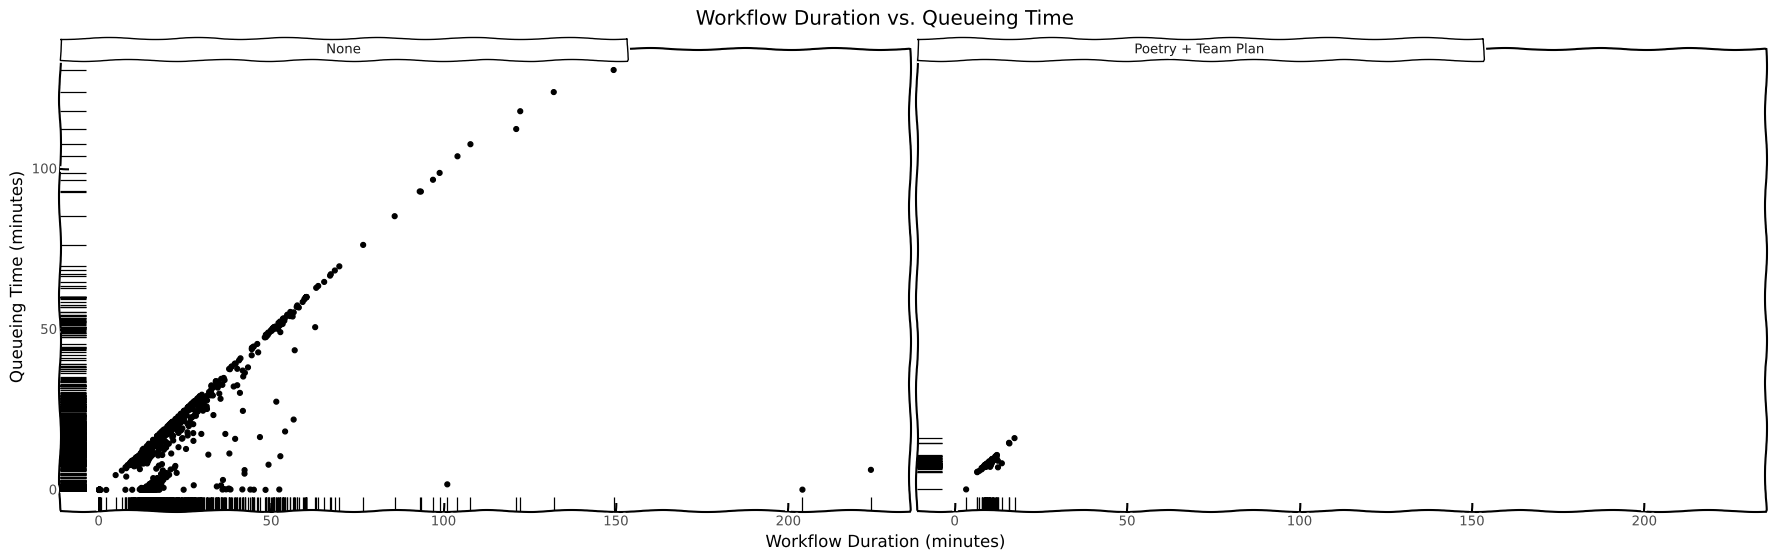

<ggplot: (8787487205632)>

In [28]:
(
    ggplot(raw_df, aes(x="workflow", y="queueing_time"))
    + geom_point()
    + geom_rug()
    + facet_grid(". ~ team_plan")
    + labs(x="Workflow Duration (minutes)", y="Queueing Time (minutes)")
    + ggtitle("Workflow Duration vs. Queueing Time")
    + theme(figure_size=(22, 6))
)

## Result #3: Workflow Duration and Queueing Duration are correlated

It also seems that moving to the team plan (though also the move to poetry might be related here) reduced the variability of both metrics.

We're lacking data compared to the past so we should wait for more to come in.

## Conclusions

It appears that you need both a short queue time **and** fast individual jobs to minimize time spent in CI.

If you have a short queue time, but long job runs then you'll be bottlenecked on individual jobs, and if you have more jobs than queue slots then you'll be blocked on queueing time.

I think we can sum this up nicely:

- slow jobs, slow queue: 🤷 blocked by jobs or queue
- slow jobs, fast queue: ❓ blocked by jobs, if jobs are slow enough
- fast jobs, slow queue: ❗ blocked by queue, with enough jobs
- fast jobs, fast queue: ✅